# Setup

In [1]:
devtools::install_github("ropensci/rnaturalearthhires")
invisible(lapply(c(
  "Cairo", "dplyr", "tidyr", "duckdb", "dbplyr", "ggplot2",
  "rnaturalearth", "rnaturalearthdata", "rnaturalearthhires",
  "sf", "gdalcubes", "terra", "tidyterra",
  "car", "corrplot", "stringr", "Hmsc"
), library, character.only = TRUE))

gdalcubes_options(parallel = TRUE)

custom_palette <- c(
  "#0072B2",  "#D55E00", "#CC79A7", "#009E73", "#E69F00", "#56B4E9",
  "#F0E442", "#999999", "#000000"
)
options(
  repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300,
  repr.plot.antialias = "subpixel",
  contrasts = c("contr.sum", "contr.poly"),
  ggplot2.discrete.fill = custom_palette,
  ggplot2.discrete.colour = custom_palette
)
theme_set(
  theme_bw() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      legend.position = "top",
      legend.direction = "horizontal",
      legend.box = "vertical",
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank(),
      strip.background = element_blank(),
      axis.title = element_text(size = rel(1.1), face = "bold"),
      axis.text = element_text(size = rel(1.1), face = "bold"),
      strip.text = element_text(size = rel(1.1), face = "bold")
    )
)

Using GitHub PAT from the git credential store.

Skipping install of 'rnaturalearthhires' from a github remote, the SHA1 (153b0ea5) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: DBI


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.42


Attaching package: ‘terra’


The following objects are masked from ‘package:gdalcubes’:

    animate, crop, size


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘tidyterra’


The following object is mas

# Data

In [2]:
con <- dbConnect(
  duckdb(), dbdir = "../processing/amfungi_lsu.duckdb", read_only = FALSE
)
inner_join(
  tbl(con, "occurances") |> select(sample_id, taxon_id, abundance, total),
  tbl(con, "samples") |> select(id, longitude, latitude),
  by = join_by(sample_id == id)
) |>
  inner_join(
    tbl(con, "taxa") |> select(taxa_id, Species),
    by = join_by(taxon_id == taxa_id)
  ) |>
  compute(name = "locations")

# Source:   table<locations> [?? x 7]
# Database: DuckDB v1.3.0 [robert@Linux 6.12.33-0-generic:R 4.3.3//home/robert/Public/Github/biotic_niche_modeling/processing/amfungi_lsu.duckdb]
   sample_id taxon_id abundance  total longitude latitude Species               
   <chr>     <chr>        <int>  <int>     <dbl>    <dbl> <chr>                 
 1 7805      MT832194        12 221538    -116.      43.3 Rhizophagus irregular…
 2 7806      MT832194        41 951993    -116.      43.3 Rhizophagus irregular…
 3 7814      MT832194         2 139418    -116.      43.3 Rhizophagus irregular…
 4 8077      MT832194         5  30383    -116.      43.3 Rhizophagus irregular…
 5 7929      MT832194         2  54553    -116.      43.3 Rhizophagus irregular…
 6 8007      MT832194         1    765    -122.      48.8 Rhizophagus irregular…
 7 7806      MT832194         1 951993    -116.      43.3 Rhizophagus irregular…
 8 7807      MT832194         1  20890     -99.6     24.9 Rhizophagus irregular…
 9 780

In [3]:
occ <- collect(tbl(con, "occurances"))
loc <- collect(tbl(con, "locations"))
tax <- collect(tbl(con, "taxa"))

nrow(occ)
nrow(loc)

[1] 398074

[1] 398074

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


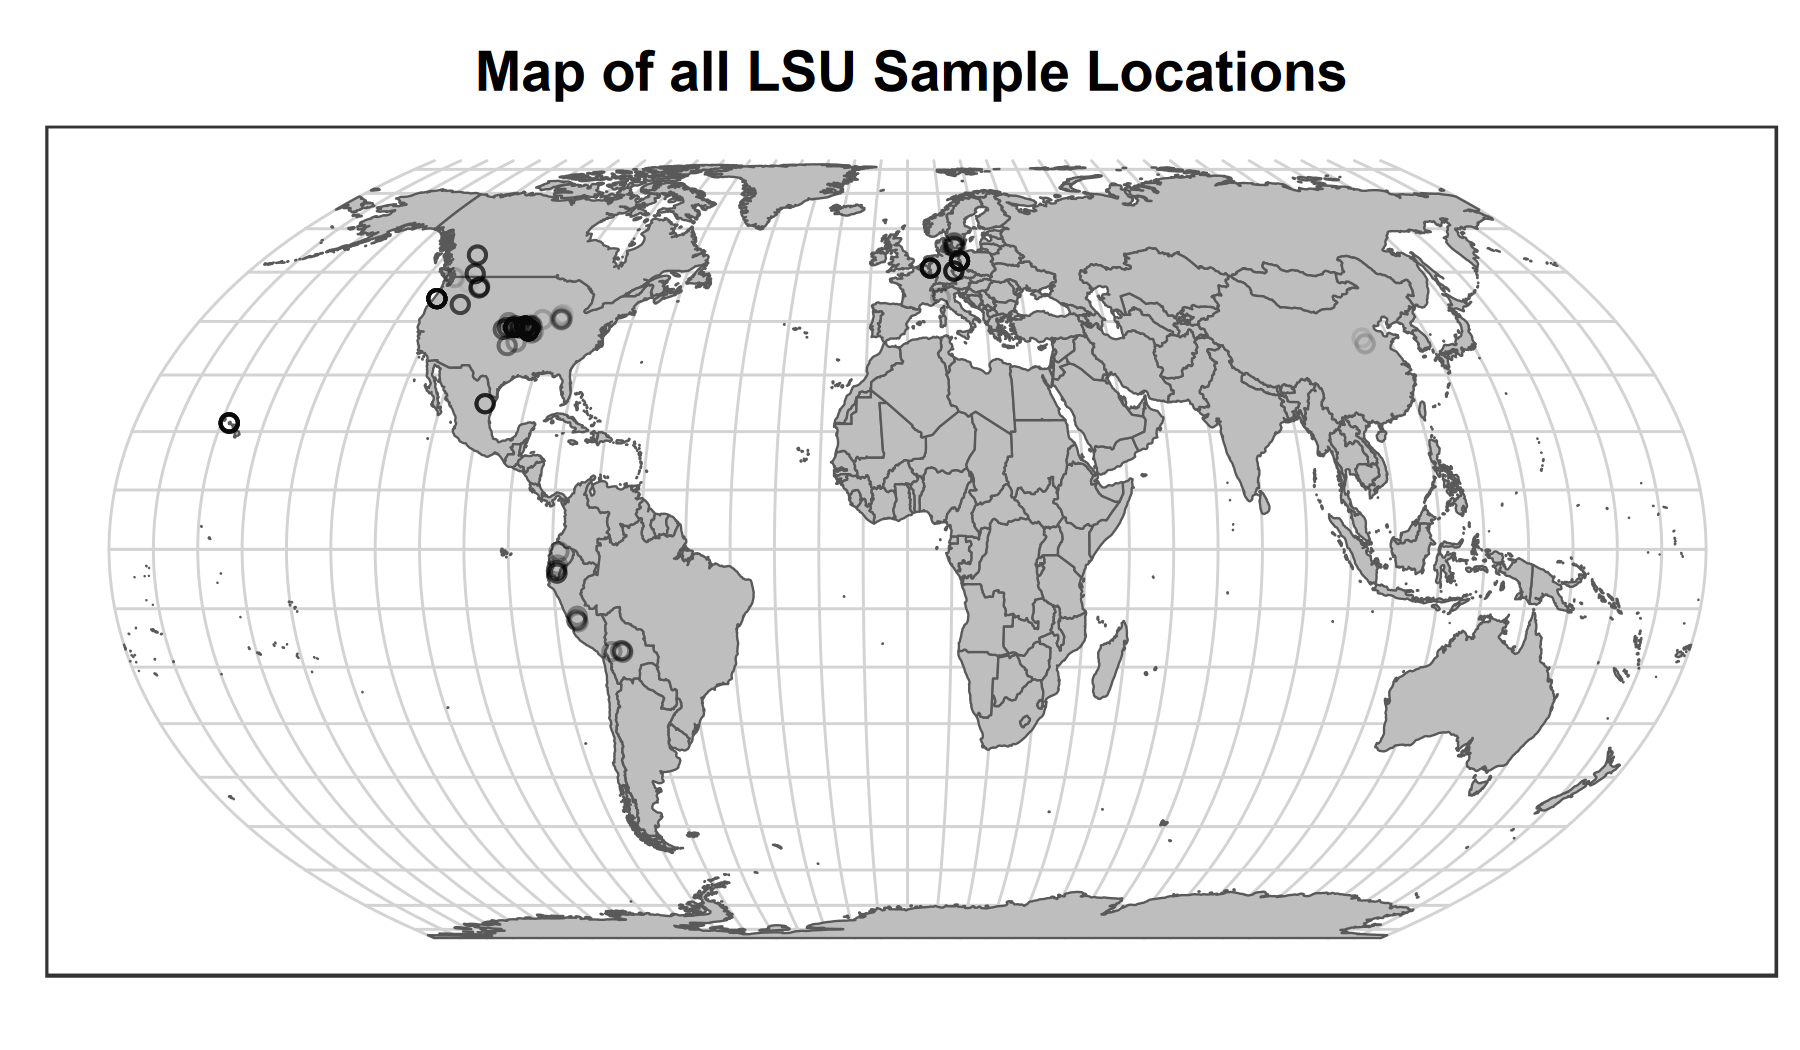

In [4]:
world <- ne_countries(scale = "medium", returnclass = "sf")
p <- ggplot(
  data = filter(tbl(con, "samples"), target_gene == "LSU")
) +
  geom_sf(
    data = world, fill = "grey", show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(crs = "WGS84 +proj=eqearth", default_crs = "EPSG:4326") +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Sample Locations"
  )
suppressWarnings(print(p))

In [5]:
count(tbl(con, "locations"), Species) |> collect() |> arrange(desc(n))


Species,n
<chr>,<dbl>
Funneliformis mosseae,223099
Rhizophagus irregularis,64614
Funneliformis caledonius,48221
Claroideoglomus sp.,12782
Funneliformis sp.,12442
Sclerocystis sinuosa,9617
Claroideoglomus claroideum,4225
Microkamienskia perpusilla,2201
Glomeraceae_spp,2128


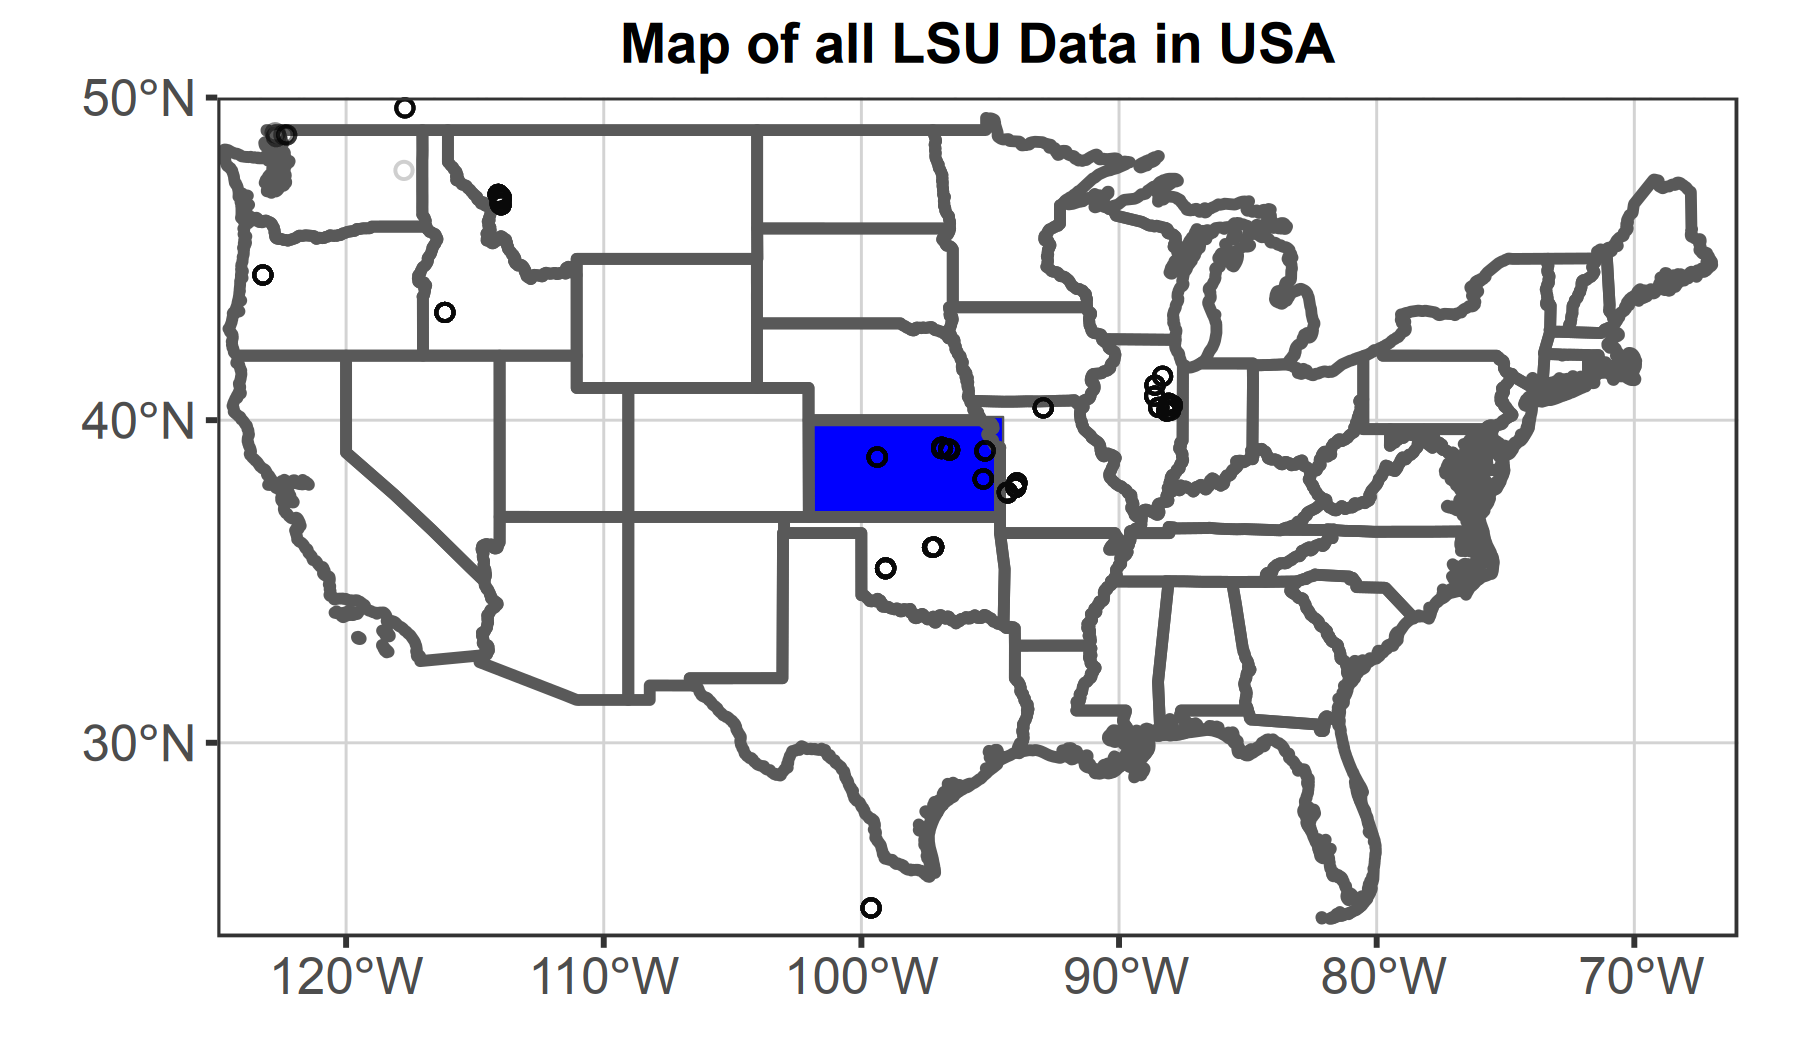

In [6]:
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
  # data = filter(tbl(con, "samples"), target_gene == "LSU")
  data = tbl(con, "locations")
) +
  geom_sf(
    data = st_as_sfc(
      st_bbox(c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1), crs = 4326)
    ), fill = "blue"
  ) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    # xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
    xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Data in USA"
  )
suppressWarnings(print(p))

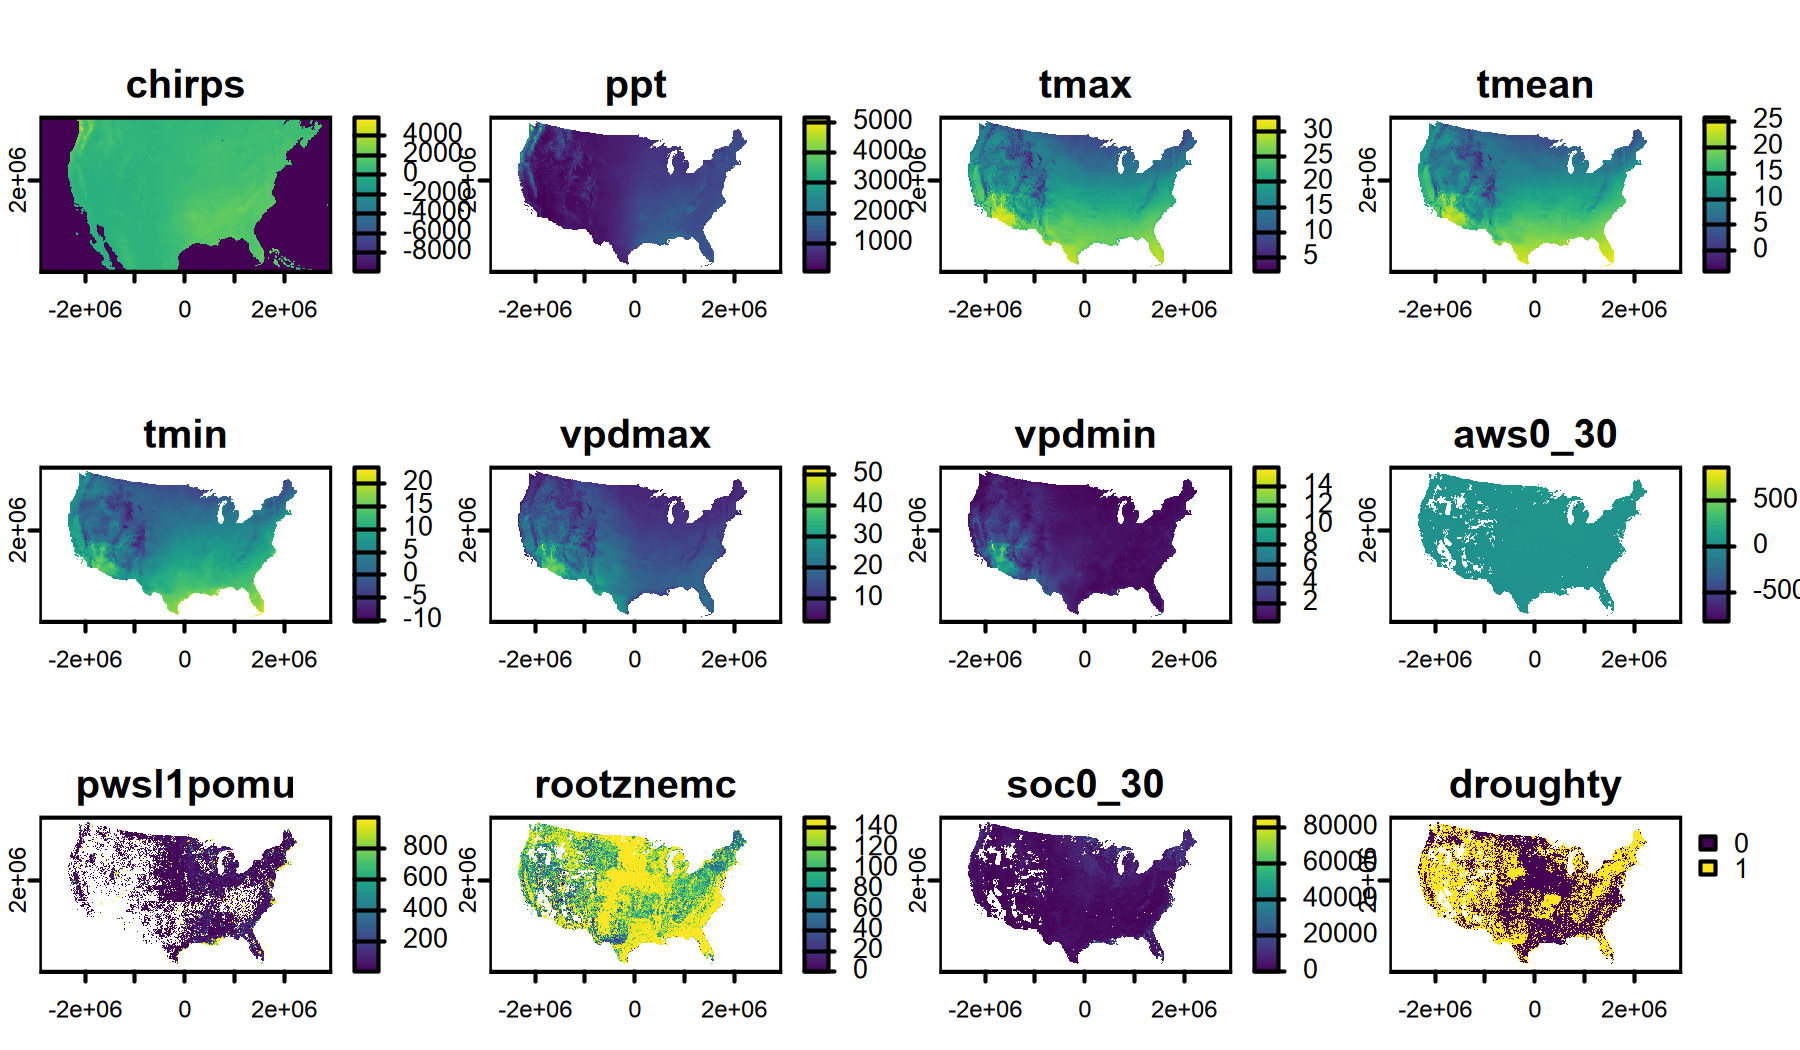

In [7]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
plot(gis_dataset)

# Midwest Only

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Species,n
<chr>,<int>
Glomeraceae_spp,2128
Rhizoglomus_sp,1834
Claroideoglomus_sp,427
Glomus_sp,305
Septoglomus_sp,273
Diversispora_sp,173
Acaulospora_sp,165
Funneliformis_sp,80
Paraglomus_sp,72


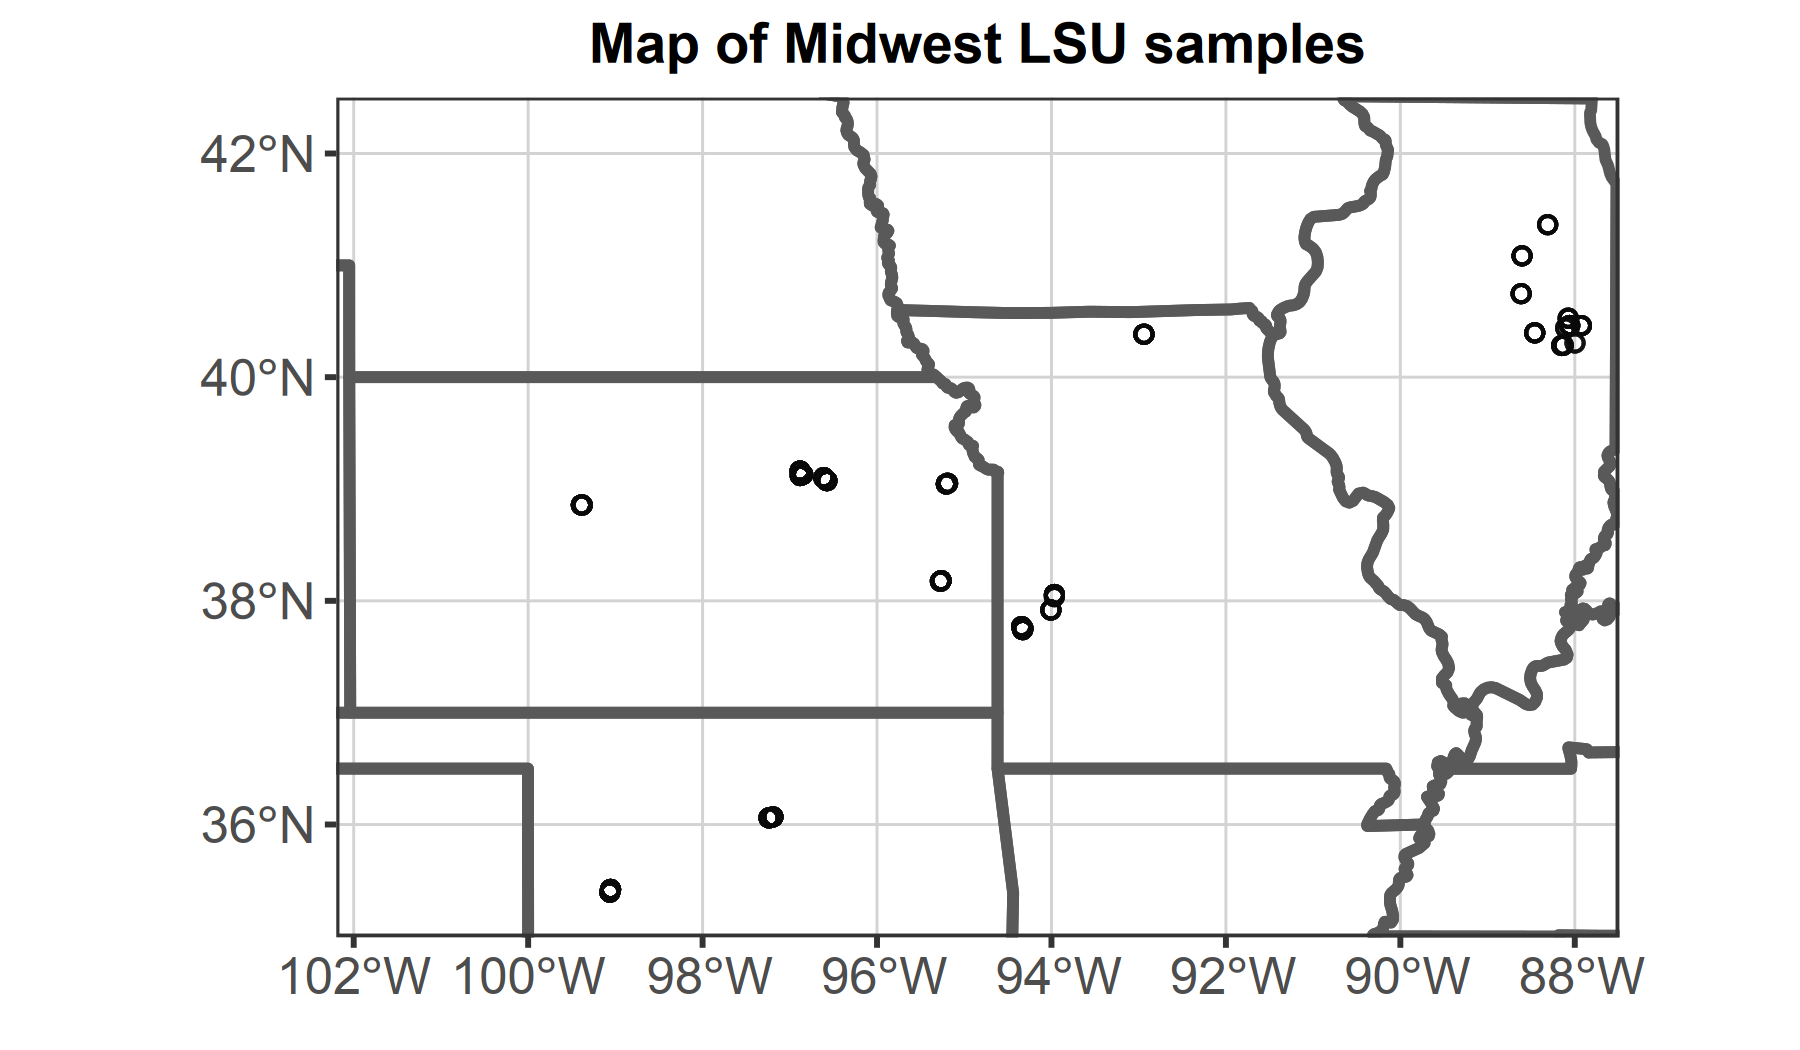

In [8]:
midwest_locations <- st_as_sf(
  collect(tbl(con, "locations")),
  coords = c('longitude', 'latitude'),
  crs = 4326
) |>
  st_crop(
    st_bbox(
      c(xmin = -102.2, xmax = -87.5, ymin = 35, ymax = 42.5),
      crs = 4326
    )
  )
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_sf(
    data = midwest_locations,
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    xlim = c(-102.2, -87.5), ylim = c(35, 42.5), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 2)) +
  scale_y_continuous(breaks = seq(-90, 90, 2)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of Midwest LSU samples"
  )
suppressWarnings(print(p))
count(st_drop_geometry(midwest_locations), Species) |> arrange(desc(n))

Warning message:
“[extract] transforming vector data to the CRS of the raster”


[1] "sample_id"  "taxon_id"   "abundance"  "total"      "Species"   
 [6] "chirps"     "ppt"        "tmax"       "tmean"      "tmin"      
[11] "vpdmax"     "vpdmin"     "aws0_30"    "pwsl1pomu"  "rootznemc" 
[16] "soc0_30"    "droughty"   "proportion"

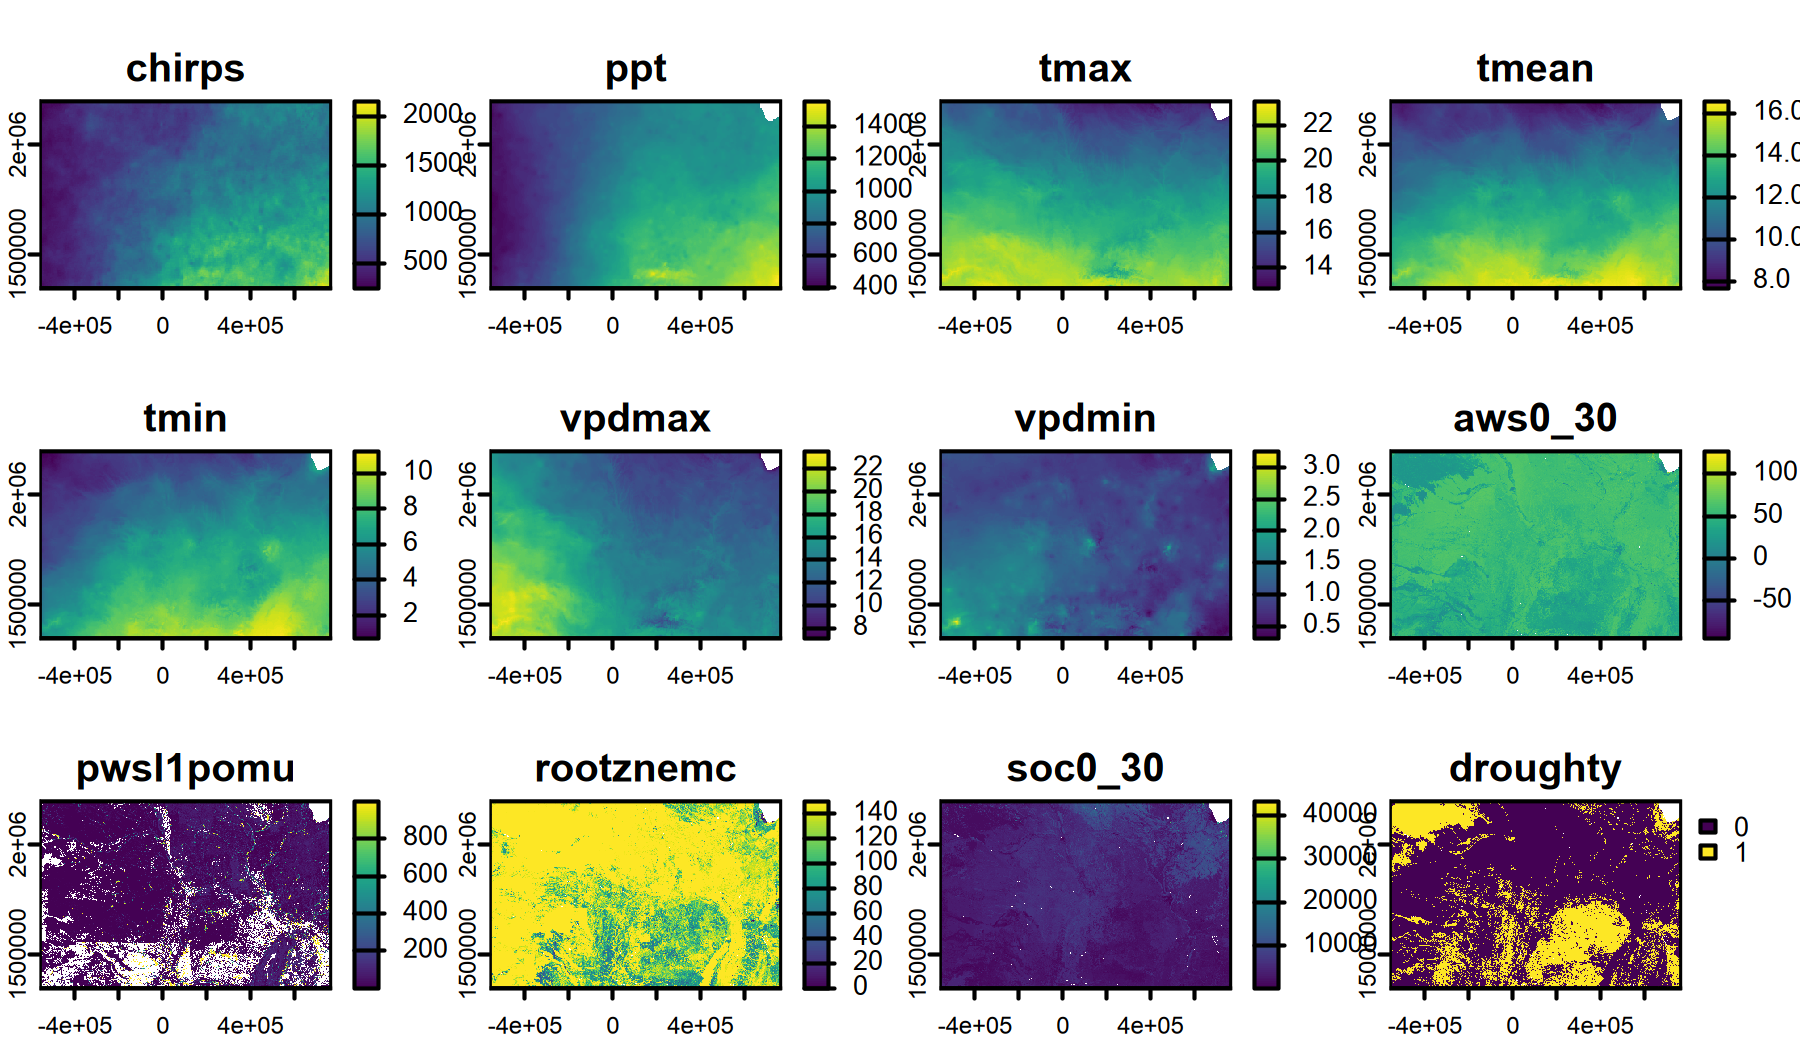

In [9]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
midwest_points <- midwest_locations
midwest_gis_dataset <- crop(
  gis_dataset,
  project(
    ext(c(-102.2, -87.5, 35, 42.5)),
    from = "EPSG:4326",
    to = "EPSG:5070"
  )
)
plot(midwest_gis_dataset)
extraction <- extract(midwest_gis_dataset, midwest_points)
dataset <- st_drop_geometry(cbind(midwest_points, extraction[, -1]))
dataset$proportion <- dataset$abundance/dataset$total
colnames(dataset)

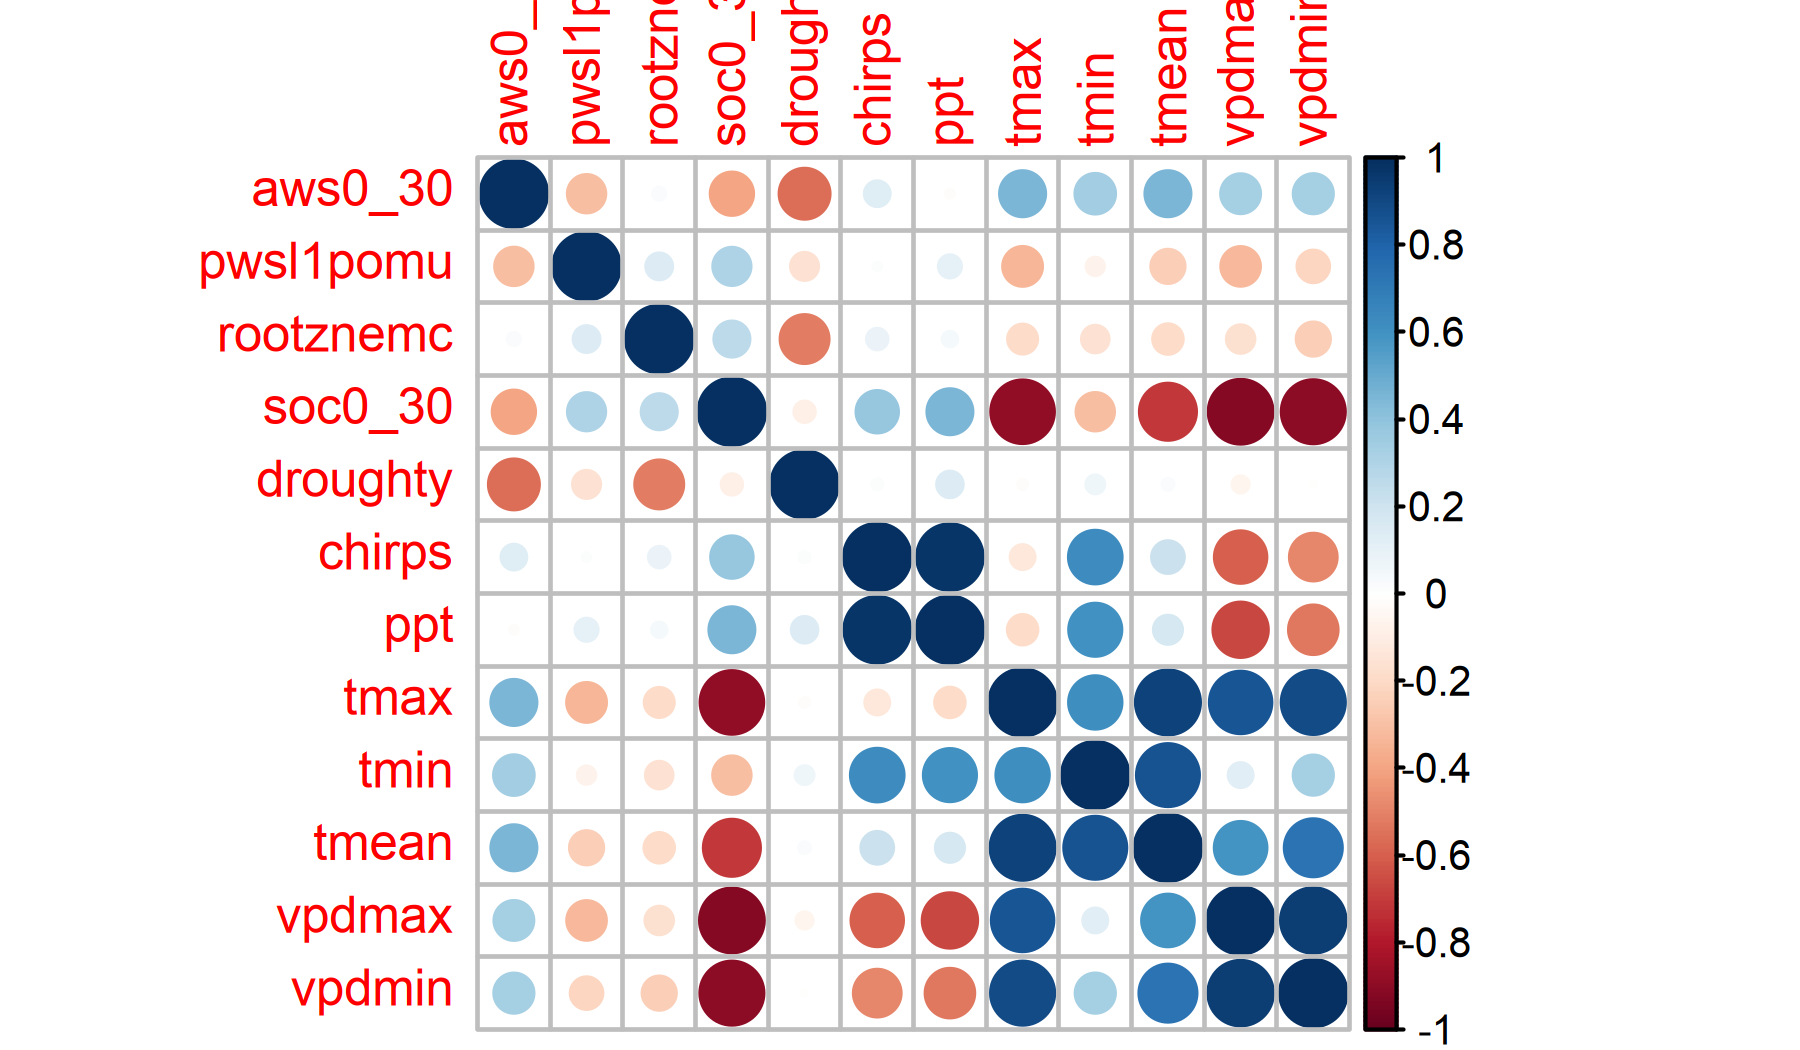

In [10]:
corrplot(cor(dataset[
  ,
  c(
    'aws0_30',
    'pwsl1pomu',
    'rootznemc',
    'soc0_30',
    'droughty',
    'chirps',
    'ppt',
    'tmax',
    'tmin',
    'tmean',
    'vpdmax',
    'vpdmin'
  )
], use = "complete.obs"), method = "circle", type = "full")

In [11]:
species_names <- c(
  "Rhizoglomus_sp", "Claroideoglomus_sp", "Glomus_sp",
  "Septoglomus_sp", "Diversispora_sp", "Acaulospora_sp"
)
# pwsl1pomu +
predictors <- c(
  "aws0_30",
  "rootznemc",
  "soc0_30",
  "droughty",
  "tmax",
  "tmin",
  "tmean",
  "vpdmax",
  "vpdmin",
  "chirps"
)
dataset_wide <- pivot_wider(
  dataset[dataset$Species %in% species_names, ],
  names_from = Species, values_from = proportion
)

m <- Hmsc(
  Y = dataset_wide[species_names],
  XData = dataset_wide[predictors],
  XFormula = ~
    aws0_30 +
    # pwsl1pomu +
    rootznemc +
    soc0_30 +
    # droughty +
    tmax +
    # tmin +
    # tmean +
    vpdmax +
    # vpdmin +
    chirps,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
  )
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 1000,
  transient = 5000,
  nChains = 20,
  nParallel = 20,
  verbose = 1
)


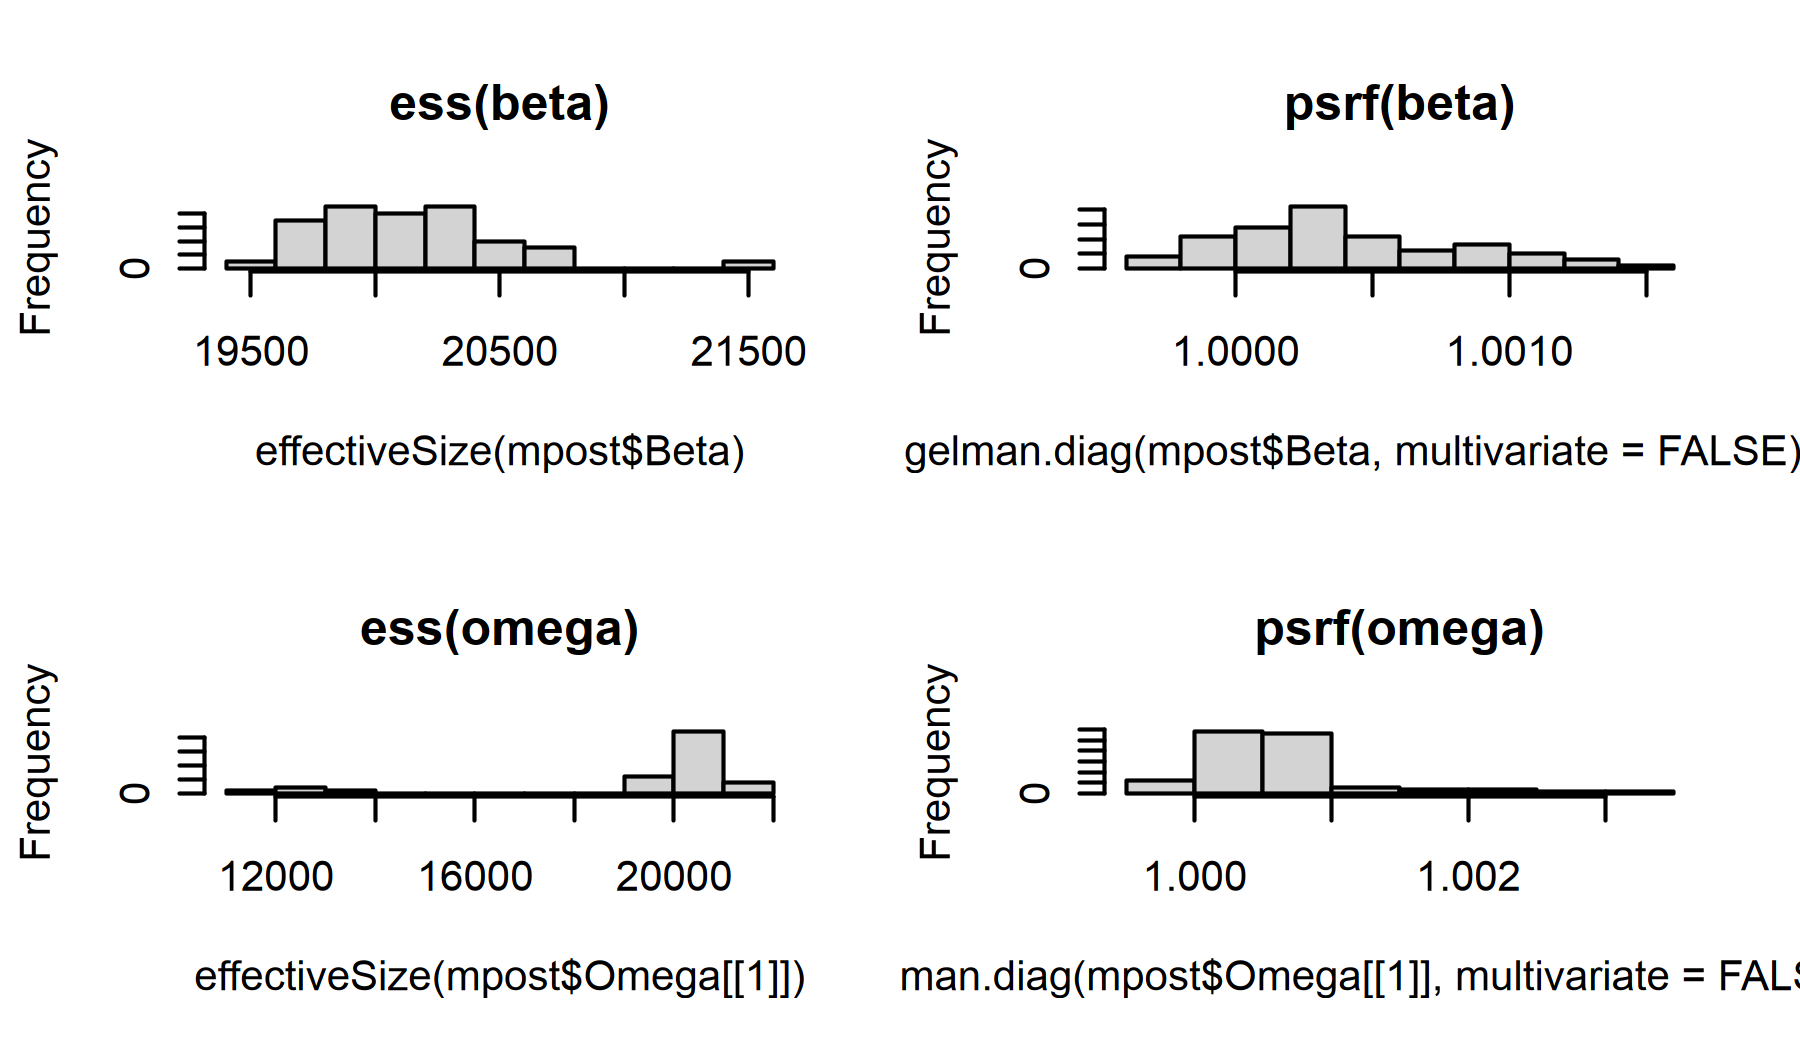

In [12]:
mpost = convertToCodaObject(m)
par(mfrow=c(2,2))
hist(effectiveSize(mpost$Beta), main="ess(beta)")
hist(gelman.diag(mpost$Beta, multivariate=FALSE)$psrf, main="psrf(beta)")
hist(effectiveSize(mpost$Omega[[1]]), main="ess(omega)")
hist(gelman.diag(mpost$Omega[[1]], multivariate=FALSE)$psrf, main="psrf(omega)")

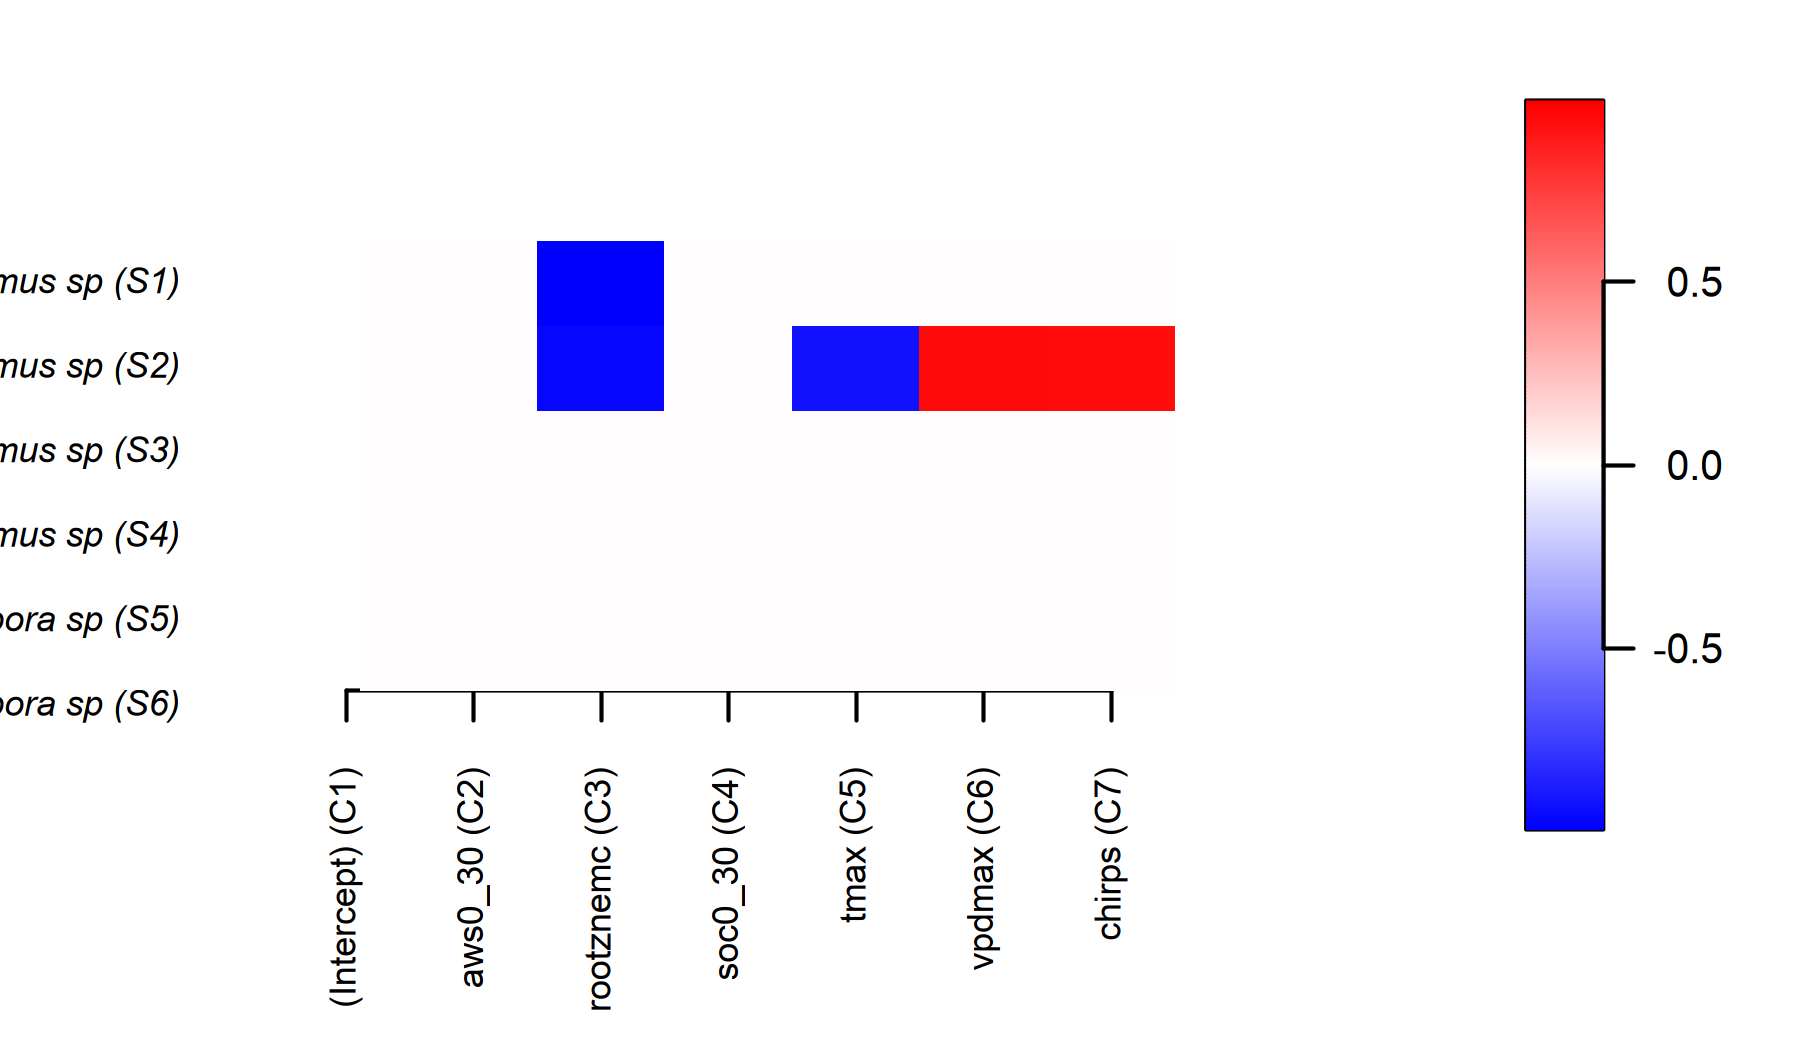

In [13]:
postBeta = getPostEstimate(m, parName="Beta")
plotBeta(m, post=postBeta, param="Support", supportLevel = 0.95)

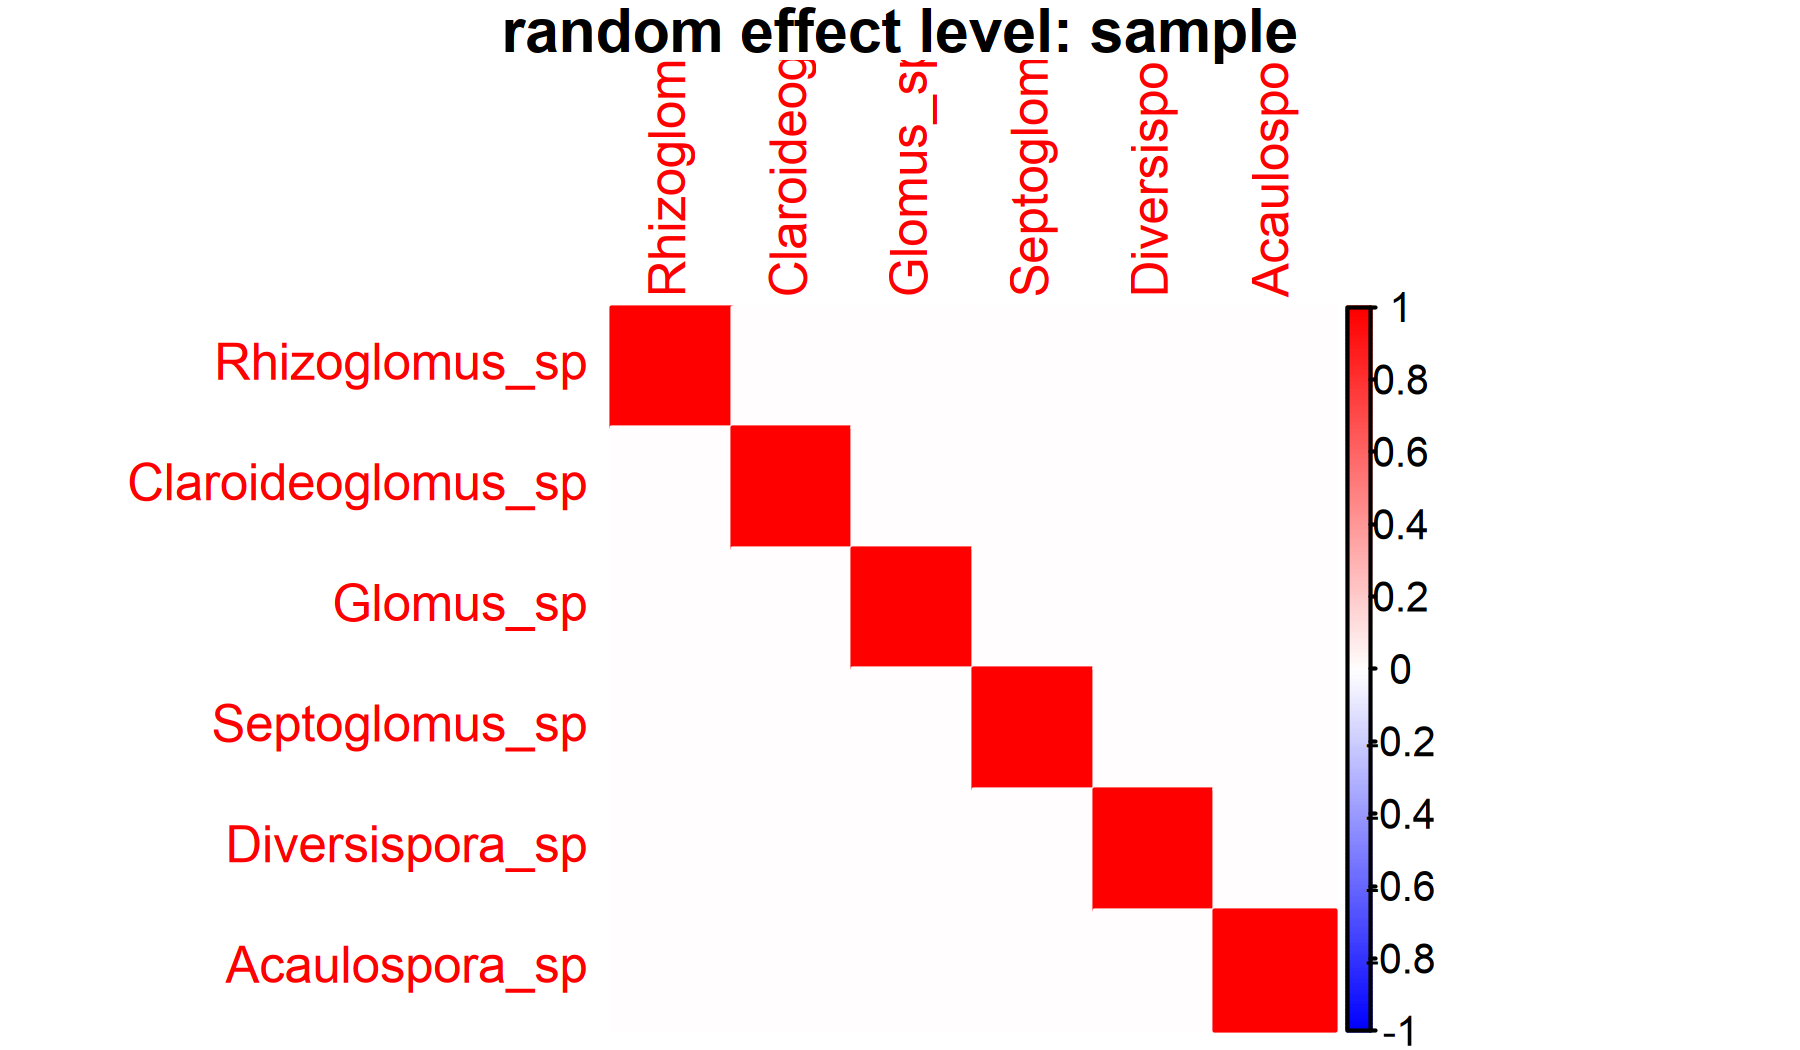

In [14]:
OmegaCor = computeAssociations(m)
supportLevel = 0.95
toPlot = ((OmegaCor[[1]]$support>supportLevel)
+ (OmegaCor[[1]]$support<(1-supportLevel))>0)*OmegaCor[[1]]$mean
corrplot(toPlot, method = "color",
col = colorRampPalette(c("blue","white","red"))(200),
title = paste("random effect level:", m$rLNames[1]), mar=c(0,0,1,0))

In [ ]:
preds = computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

$RMSE
[1] 0.012045117 0.026518710 0.006131251 0.005737362 0.000951405 0.011104740

$R2
[1] 0.10667561 0.27923554 0.06354784 0.06441293 0.09138473 0.14742425

: 

In [ ]:
partition = createPartition(m, nfolds = 2)
preds = computePredictedValues(m, partition = partition, nParallel = 20)
evaluateModelFit(hM = m, predY = preds)

In [ ]:
rL <- HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
rL$nfMin=2
rL$nfMax=2
m = Hmsc(
  Y=dataset_wide[species_names],
  XData=dataset_wide[predictors],
  XFormula=~1,
  studyDesign=data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels=list(sample=rL)
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 1000,
  transient = 5000,
  nChains = 20,
  nParallel = 20,
  verbose = 1
)

etaPost=getPostEstimate(m, "Eta")
lambdaPost=getPostEstimate(m, "Lambda")
biPlot(m, etaPost = etaPost, lambdaPost = lambdaPost, factors = c(1, 2))

In [ ]:
etaPost=getPostEstimate(m, "Eta")
lambdaPost=getPostEstimate(m, "Lambda")
biPlot(m, etaPost = etaPost, lambdaPost = lambdaPost, factors = c(1,2), "x2")

# Kansas Only

In [ ]:
kansas_locations <- st_as_sf(
  collect(tbl(con, "locations")),
  coords = c('longitude', 'latitude'),
  crs = 4326
) |>
  st_crop(
    st_bbox(
      c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1),
      crs = 4326
    )
  )
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_sf(
    data = kansas_locations,
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 2)) +
  scale_y_continuous(breaks = seq(-90, 90, 2)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of Kansas LSU samples"
  )
suppressWarnings(print(p))
count(st_drop_geometry(kansas_locations), Species) |> arrange(desc(n))

In [ ]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
plot(gis_dataset)

In [ ]:
lsu_points <- kansas_locations
kansas_gis_dataset <- crop(
  gis_dataset,
  project(
    ext(c(-102.2, -94.5, 36.9, 40.1)),
    from = "EPSG:4326",
    to = "EPSG:5070"
  )
)
plot(kansas_gis_dataset)
extraction <- extract(kansas_gis_dataset, lsu_points)
dataset <- st_drop_geometry(cbind(lsu_points, extraction[, -1]))
dataset$proportion <- dataset$abundance/dataset$total
colnames(dataset)

In [ ]:
# ggcorplot(
#   cor(dataset[dataset$Species == "Rhizophagus irregularis", ])
# )
corrplot(cor(dataset[
  ,
  c(
    'aws0_30',
    'pwsl1pomu',
    'rootznemc',
    'soc0_30',
    'droughty',
    'chirps',
    'ppt',
    'tmax',
    'tmin',
    'tmean',
    'vpdmax',
    'vpdmin'
  )
], use = "complete.obs"), method = "circle", type = "full")

In [ ]:
unique(dataset$Species)
count(st_drop_geometry(kansas_locations), Species) |> arrange(desc(n))

In [ ]:
species_names <- c("Rhizoglomus_sp", "Claroideoglomus_sp", "Septoglomus_sp", "Glomus_sp")
# pwsl1pomu +
predictors <- c(
  "aws0_30",
  "rootznemc",
  "soc0_30",
  "droughty",
  "tmax",
  "tmin",
  "tmean",
  "vpdmax",
  "vpdmin",
  "chirps"
)
dataset_wide <- pivot_wider(
  dataset[dataset$Species %in% species_names, ],
  names_from = Species, values_from = proportion
)
# which(is.na(dataset_wide[!(colnames(dataset_wide) %in% species_names)]), arr.ind=TRUE)
# studyDesign <- data.frame(sample = as.factor(row.names(dataset_wide)))

m <- Hmsc(
  Y = dataset_wide[species_names],
  XData = dataset_wide[predictors],
  XFormula = ~
    aws0_30 +
    # pwsl1pomu +
    rootznemc +
    soc0_30 +
    # droughty +
    tmax +
    # tmin +
    # tmean +
    vpdmax +
    # vpdmin +
    chirps,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
  )
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 1000,
  transient = 5000,
  nChains = 20,
  nParallel = 20,
  verbose = 1
)


In [ ]:
mpost = convertToCodaObject(m)
par(mfrow=c(2,2))
hist(effectiveSize(mpost$Beta), main="ess(beta)")
hist(gelman.diag(mpost$Beta, multivariate=FALSE)$psrf, main="psrf(beta)")
hist(effectiveSize(mpost$Omega[[1]]), main="ess(omega)")
hist(gelman.diag(mpost$Omega[[1]], multivariate=FALSE)$psrf, main="psrf(omega)")


In [ ]:
postBeta = getPostEstimate(m, parName="Beta")
plotBeta(m, post=postBeta, param="Support", supportLevel = 0.5)

In [ ]:
OmegaCor = computeAssociations(m)
supportLevel = 0.95
toPlot = ((OmegaCor[[1]]$support>supportLevel)
+ (OmegaCor[[1]]$support<(1-supportLevel))>0)*OmegaCor[[1]]$mean
corrplot(toPlot, method = "color",
col = colorRampPalette(c("blue","white","red"))(200),
title = paste("random effect level:", m$rLNames[1]), mar=c(0,0,1,0))

In [ ]:
preds = computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

In [ ]:
partition = createPartition(m, nfolds = 2)
preds = computePredictedValues(m, partition = partition, nParallel = 8)
evaluateModelFit(hM = m, predY = preds)

In [ ]:
rL <- HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
rL$nfMin=2
rL$nfMax=2
m = Hmsc(
  Y=dataset_wide[species_names],
  XData=dataset_wide[predictors],
  XFormula=~1,
  studyDesign=data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels=list(sample=rL)
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 1000,
  transient = 5000,
  nChains = 20,
  nParallel = 20,
  verbose = 1
)

etaPost=getPostEstimate(m, "Eta")
lambdaPost=getPostEstimate(m, "Lambda")
biPlot(m, etaPost = etaPost, lambdaPost = lambdaPost, factors = c(1, 2))

## Regressions

In [ ]:
# distr = c("normal","probit","poisson","lognormal poisson")

In [ ]:
for(species in species_names) {
  histogram_plot <- ggplot(data = dataset[dataset$Species == species, ]) +
    geom_histogram(aes(x = log(abundance/total))) +
    labs(title = species)
  print(histogram_plot)

  model <- glm(
    proportion ~
      aws0_30 +
      # pwsl1pomu +
      rootznemc +
      soc0_30 +
      # droughty +
      # tmax +
      # tmin +
      # tmean +
      # vpdmax +
      # vpdmin +
      chirps
    ,
    family = gaussian(link = "log"),
    data = dataset[dataset$Species == species, ]
  )
  print(summary(model))
  print(Anova(model, type = 2))

  output <- predict(kansas_gis_dataset, model)
  niche_model_map <- ggplot() +
    geom_spatraster(data = output, aes(fill = lyr1)) +
    labs(x = NULL, y = NULL) +
    coord_sf(
      crs = "WGS84", default_crs = "WGS84",
      xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
    ) +
    scale_x_continuous(breaks = seq(-180, 180, 2)) +
    scale_y_continuous(breaks = seq(-90, 90, 2)) +
    scale_fill_gradient(
      low = "black",
      high = "lightgreen",
      na.value = "white"
    ) +
    theme(
      legend.position = "right",
      legend.direction = "vertical",
      axis.text.y = element_text(angle = 90, hjust = 0.5)
    )
  print(niche_model_map)
}

In [ ]:
dbDisconnect(con, shutdown = TRUE)